In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import os
from pathlib import Path
os.environ["POLARS_MAX_THREADS"] = "80"
import polars as pl
import polars.selectors as cs

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42

In [30]:
figdir = Path("figures/counts")

In [31]:
def savefig(p: so.Plot, basename: str):
    for ext in ["png", "svg", "pdf"]:
        p.save(figdir / f"{basename}.{ext}", bbox_inches="tight", dpi=300)

In [3]:
def print_df(df: pl.DataFrame, n_rows: int = 100, str_length: int = 200, **kwargs):
    with pl.Config(fmt_str_lengths=str_length, set_tbl_rows=n_rows, **kwargs):
        display(df)

In [15]:
colors = {
    "Archaea": "#ff6b6b",
    "Bacteria": "#8ac926",
}

In [32]:
threshold = 250
data = (
    pl.read_csv("provirus_counts.tsv", separator="\t")
    .with_columns(
        vh_ratio = pl.col("provirus_count") / pl.col("host_count"),
        phyla_label = (
            pl.when(
                (pl.col("provirus_count") <= threshold) |
                (pl.col("host_count") <= threshold)
            )
            .then(pl.concat_str(pl.lit("Other"), pl.col("domain"), separator=" "))
            .otherwise(pl.col("phylum"))
        )
    )
    .group_by("phyla_label")
    .agg(
        pl.sum("provirus_count", "host_count"),
        pl.first("domain"),
    )
    # .sort(["vh_ratio", "provirus_count", "host_count"], descending=True)
    .sort(["domain", "phyla_label"])
    .with_row_index()
    .with_columns(
        color = pl.col("domain").replace(colors),
    )
)
data

index,phyla_label,provirus_count,host_count,domain,color
u32,str,i64,i64,str,str
0,"""Halobacteriota…",1505,794,"""Archaea""","""#ff6b6b"""
1,"""Nanoarchaeota""",2263,748,"""Archaea""","""#ff6b6b"""
2,"""Other Archaea""",3162,896,"""Archaea""","""#ff6b6b"""
3,"""Thermoplasmato…",994,523,"""Archaea""","""#ff6b6b"""
4,"""Thermoproteota…",2440,962,"""Archaea""","""#ff6b6b"""
5,"""Acidobacteriot…",8420,3496,"""Bacteria""","""#8ac926"""
6,"""Actinobacterio…",13661,5409,"""Bacteria""","""#8ac926"""
7,"""Actinomycetota…",10127,5005,"""Bacteria""","""#8ac926"""
8,"""Armatimonadota…",1282,396,"""Bacteria""","""#8ac926"""


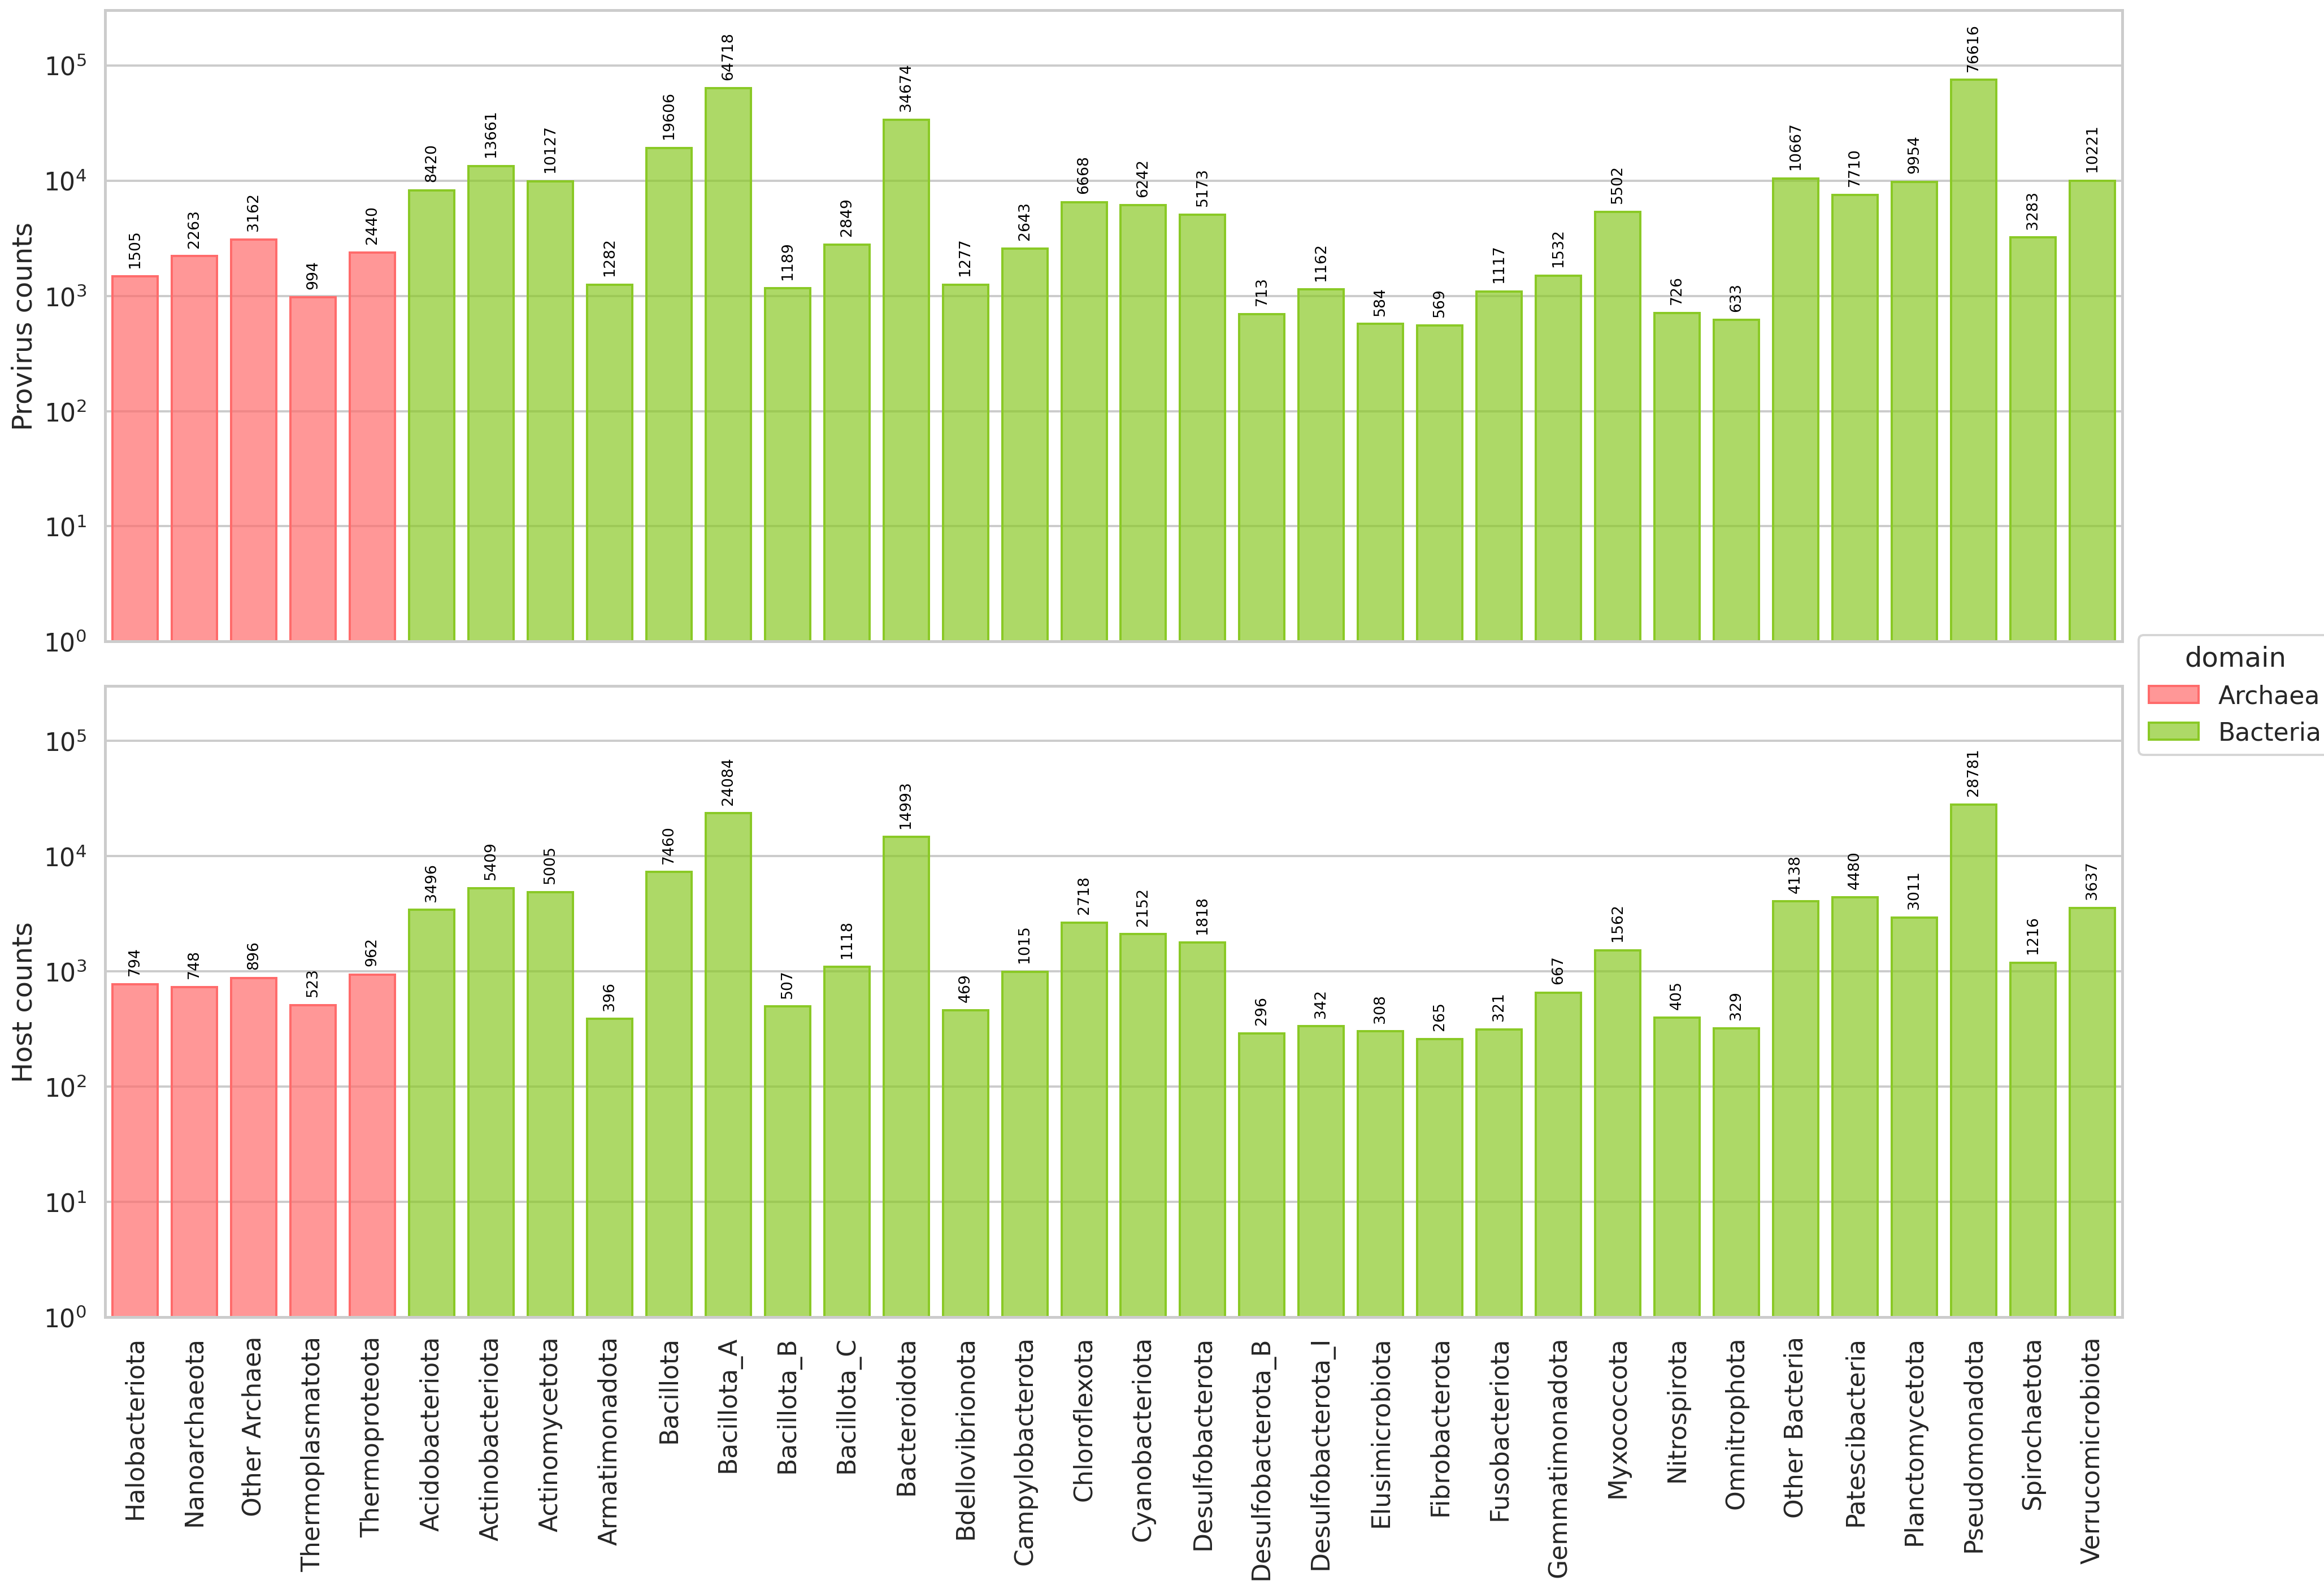

In [33]:
p = (
    so.Plot(
        data=data,
        x="phyla_label",
        color="domain",
    )
    .pair(y=["provirus_count", "host_count"])
    .add(so.Bar())
    .theme(sns.axes_style("whitegrid") | sns.plotting_context("talk"))
    .layout(size=(20,15))
    .label(x="", y0="Provirus counts", y1="Host counts")
    .share(y=True)
    .scale(color=colors)
    .plot()
)

ax: plt.Axes
for ax in p._figure.axes:
    ax.tick_params(axis="x", rotation=90)
    ax.set_yscale("log")
    ax.set_ylim(1, 300_000)

    for bars in ax.containers:
        ax.bar_label(bars, padding=5, rotation=90)

savefig(p, "log_scaled_counts")

p

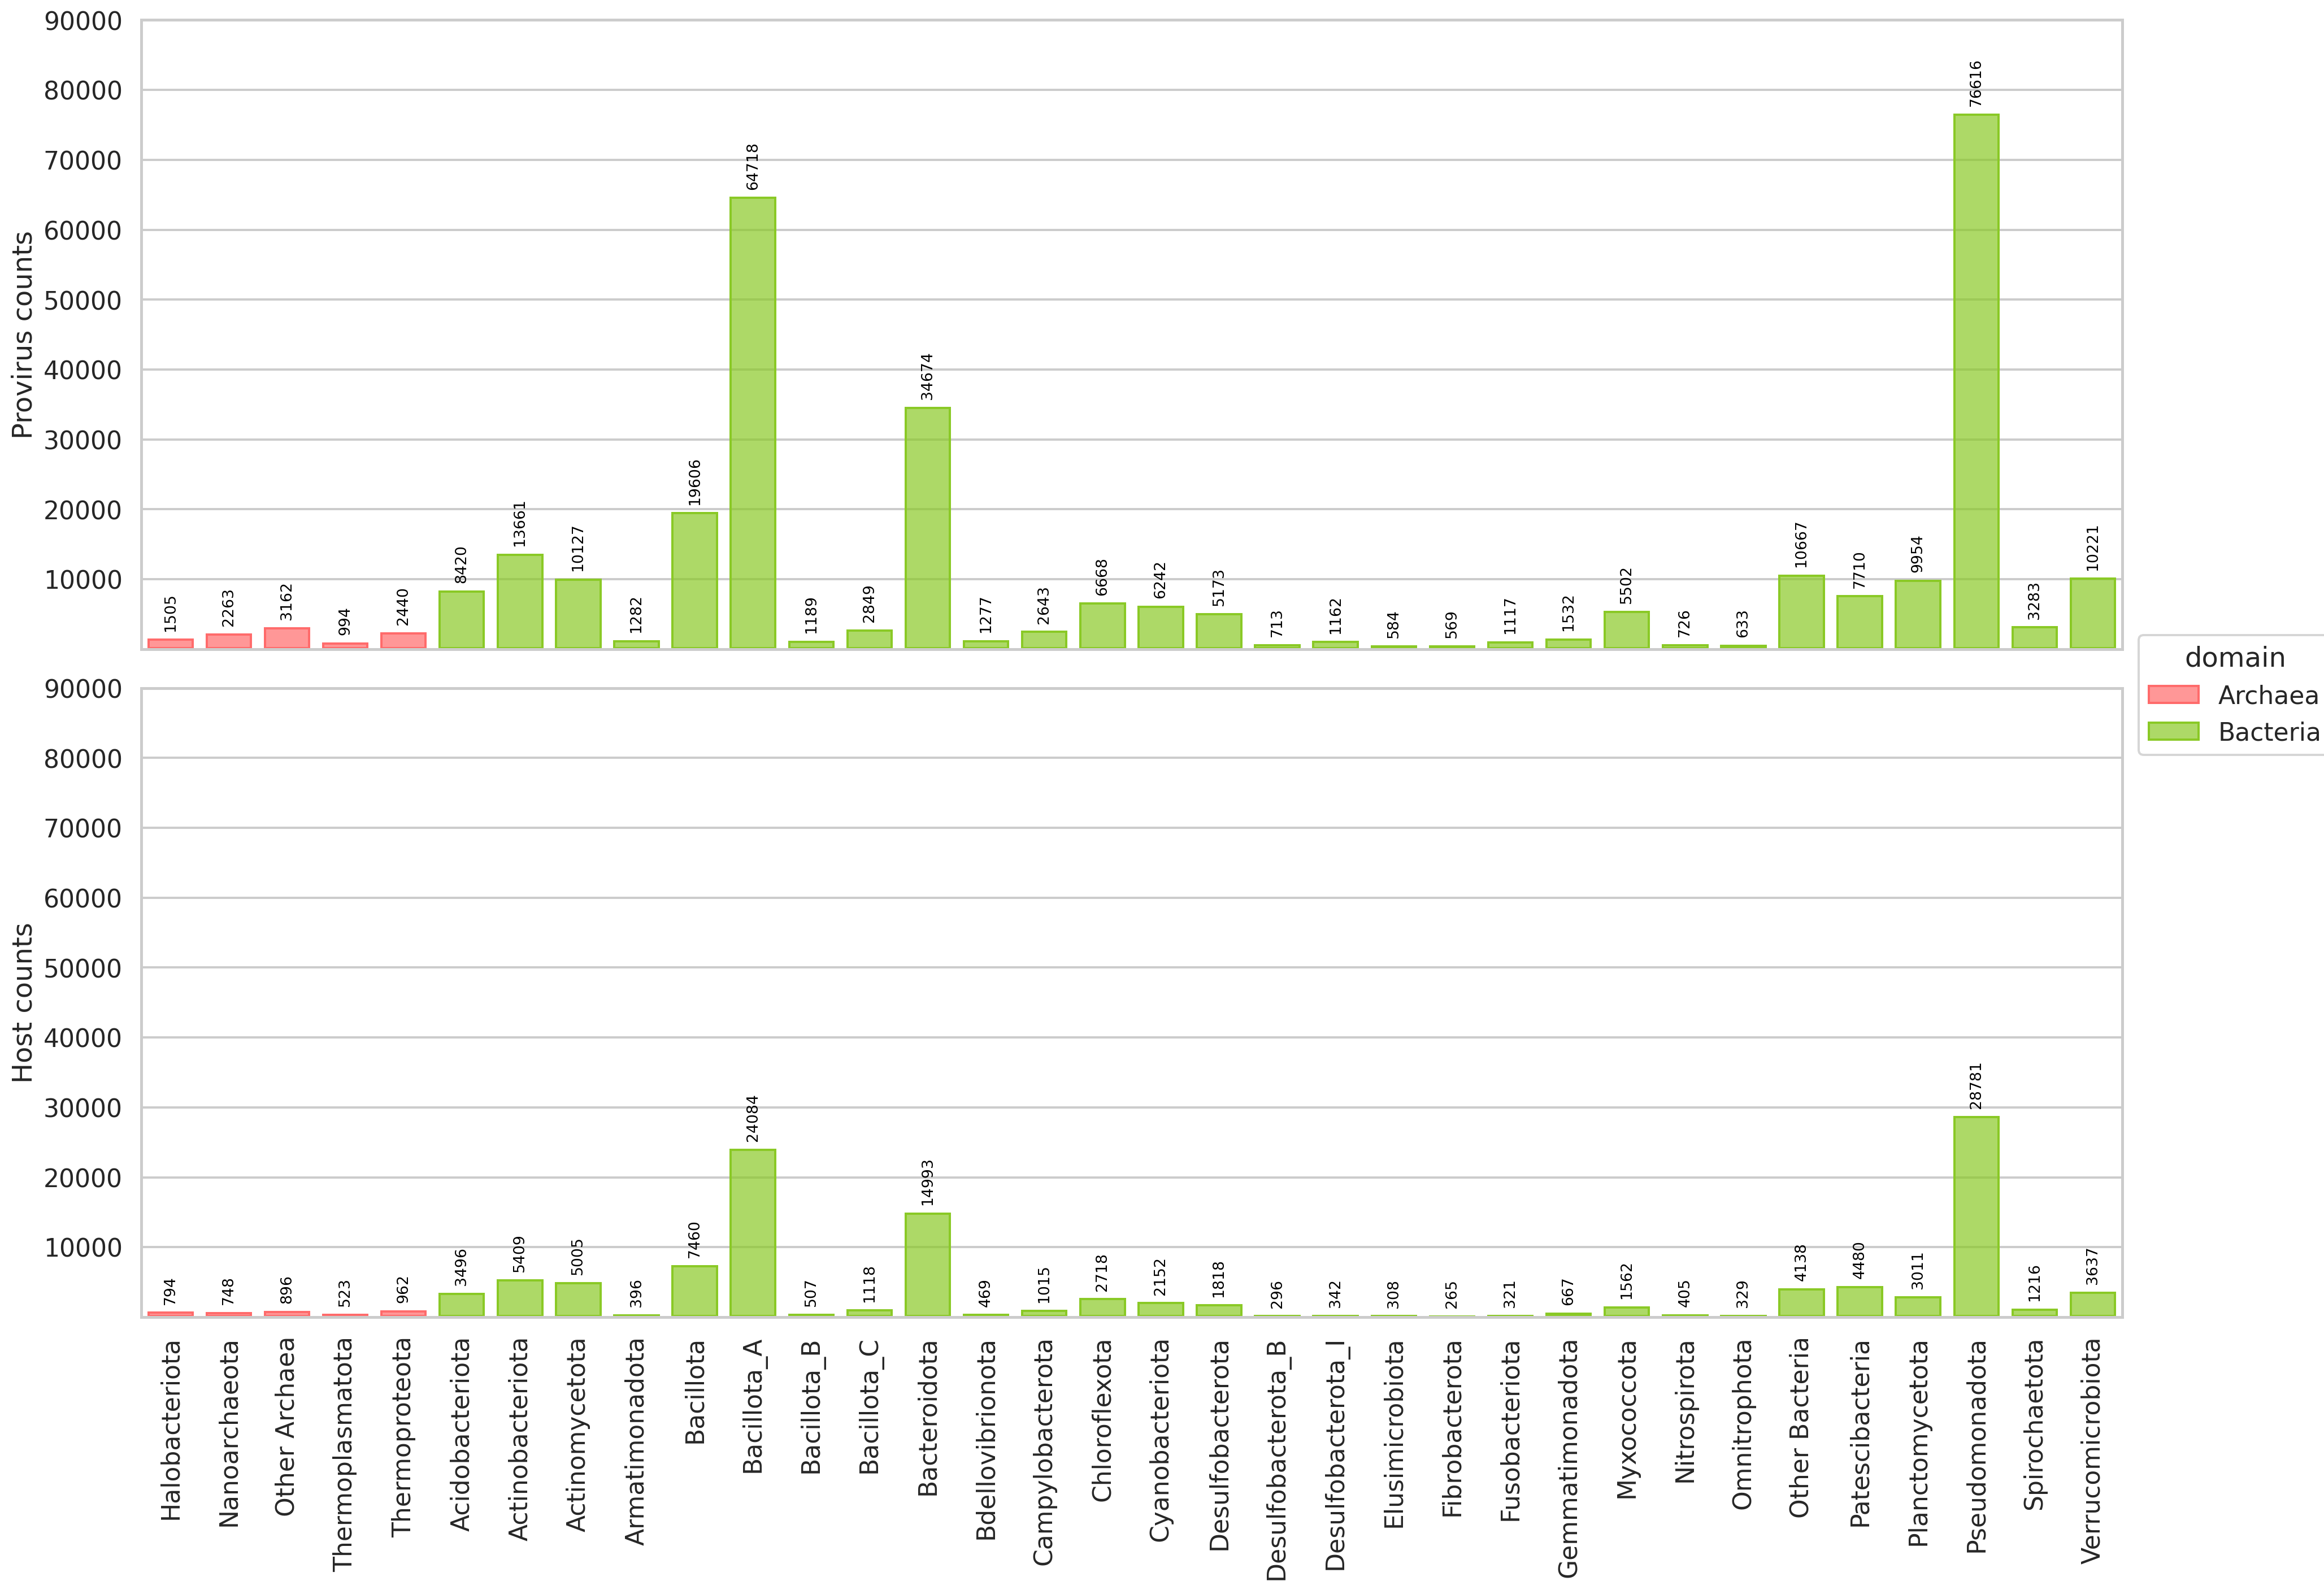

In [34]:
p = (
    so.Plot(
        data=data,
        x="phyla_label",
        color="domain",
    )
    .pair(y=["provirus_count", "host_count"])
    .add(so.Bar())
    .theme(sns.axes_style("whitegrid") | sns.plotting_context("talk"))
    .layout(size=(20,15))
    .label(x="", y0="Provirus counts", y1="Host counts")
    .share(y=True)
    .scale(color=colors)
    .plot()
)

ax: plt.Axes
for ax in p._figure.axes:
    ax.tick_params(axis="x", rotation=90)
    # ax.set_yscale("log")
    ax.set_ylim(1, 90_000)

    for bars in ax.containers:
        ax.bar_label(bars, padding=5, rotation=90)

savefig(p, "counts")

p

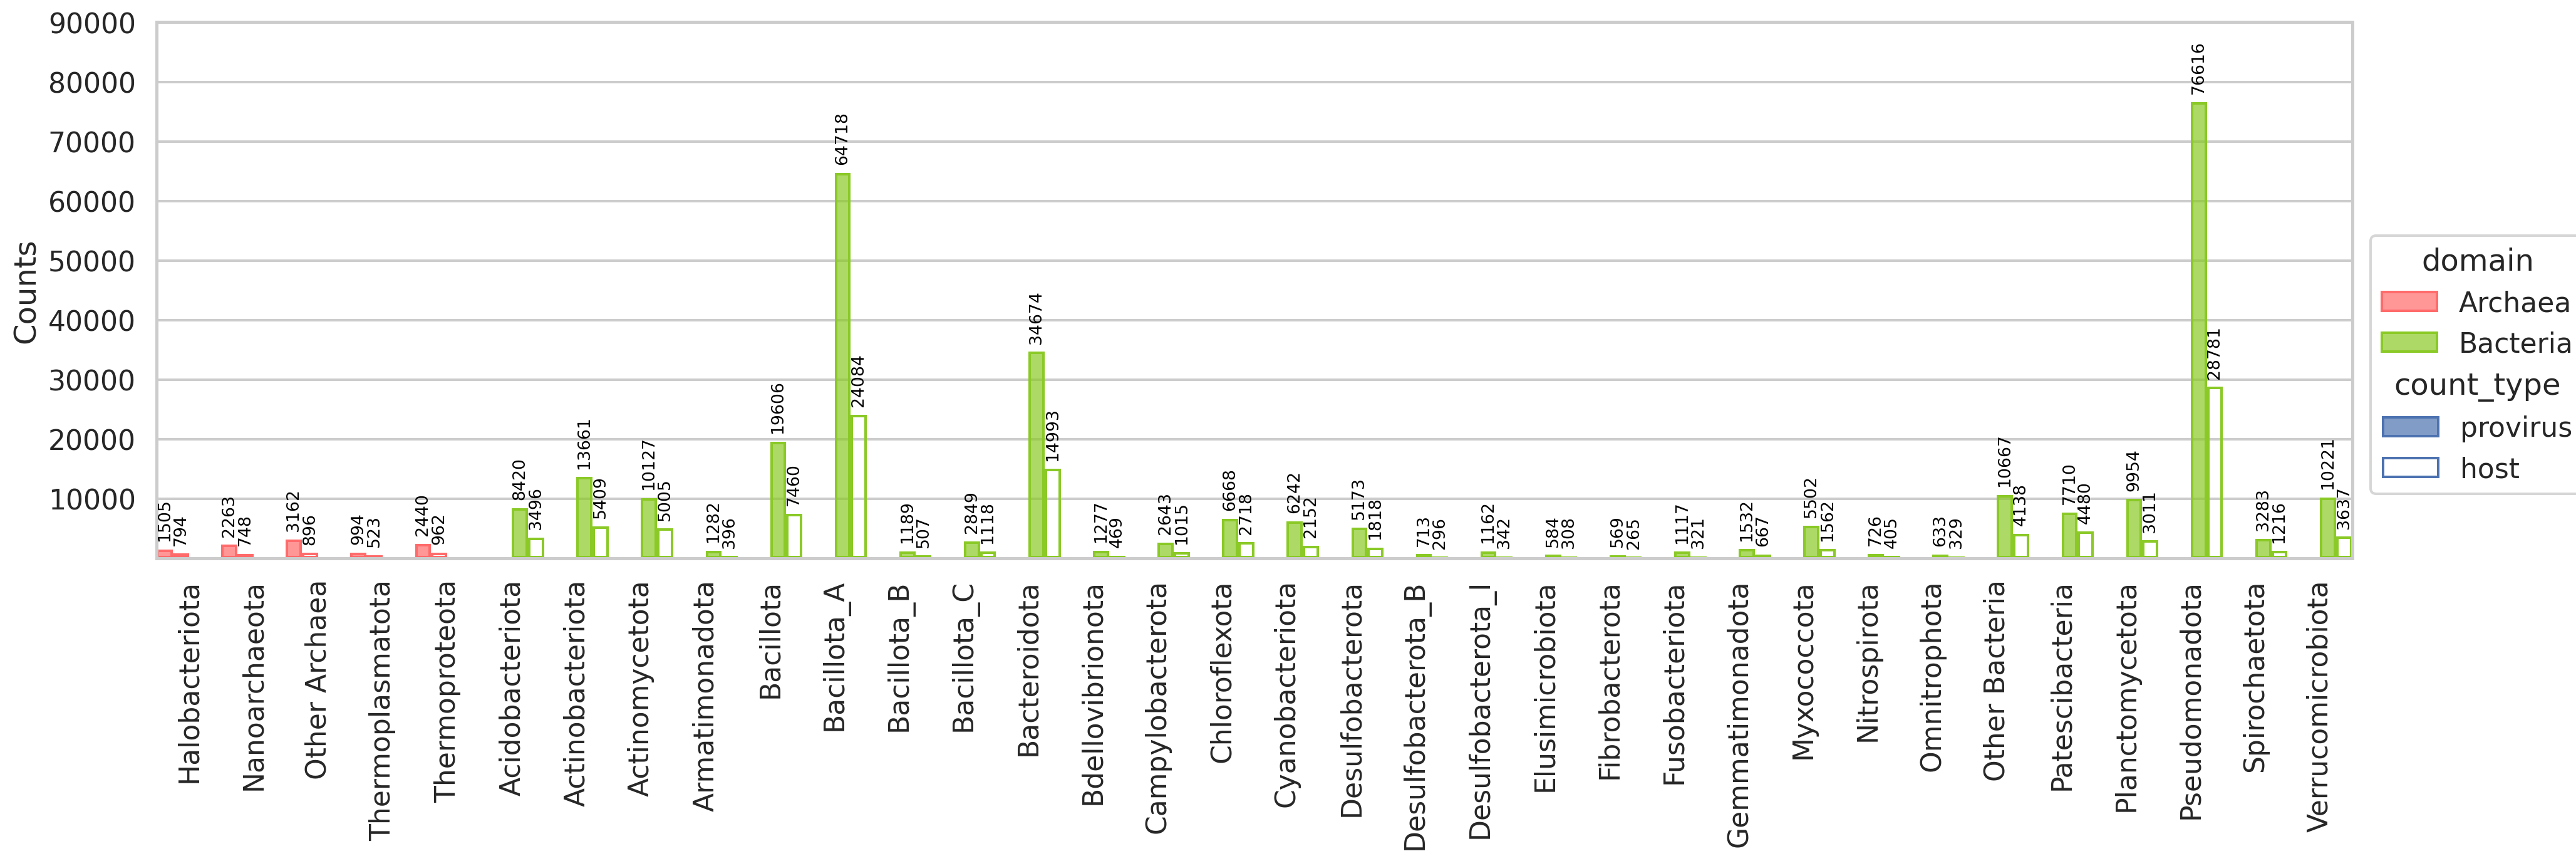

In [35]:
side_data = pl.concat(
    [
        (
            data
            .select("domain", "phyla_label", "provirus_count")
            .with_columns(count_type = pl.lit("provirus"))
            .rename({"provirus_count": "count"})
        ),

        (
            data
            .select("domain", "phyla_label", "host_count")
            .with_columns(count_type = pl.lit("host"))
            .rename({"host_count": "count"})
        ),
    ]
)

p = (
    so.Plot(
        data=side_data,
        x="phyla_label",
        y="count",
        color="domain",
        fill="count_type",
    )
    .add(so.Bar(width=1.0), so.Dodge())
    .theme(sns.axes_style("whitegrid") | sns.plotting_context("talk"))
    .layout(size=(20,7.5))
    .label(x="", y="Counts")
    .share(y=True)
    .scale(color=colors)
    .plot()
)

ax: plt.Axes
for ax in p._figure.axes:
    ax.tick_params(axis="x", rotation=90)
    # ax.set_yscale("log")
    ax.set_ylim(1, 90_000)

    for bars in ax.containers:
        ax.bar_label(bars, padding=5, rotation=90)

savefig(p, "side_by_side_counts")

p

In [8]:
from pycirclize import Circos

In [9]:
import numpy as np

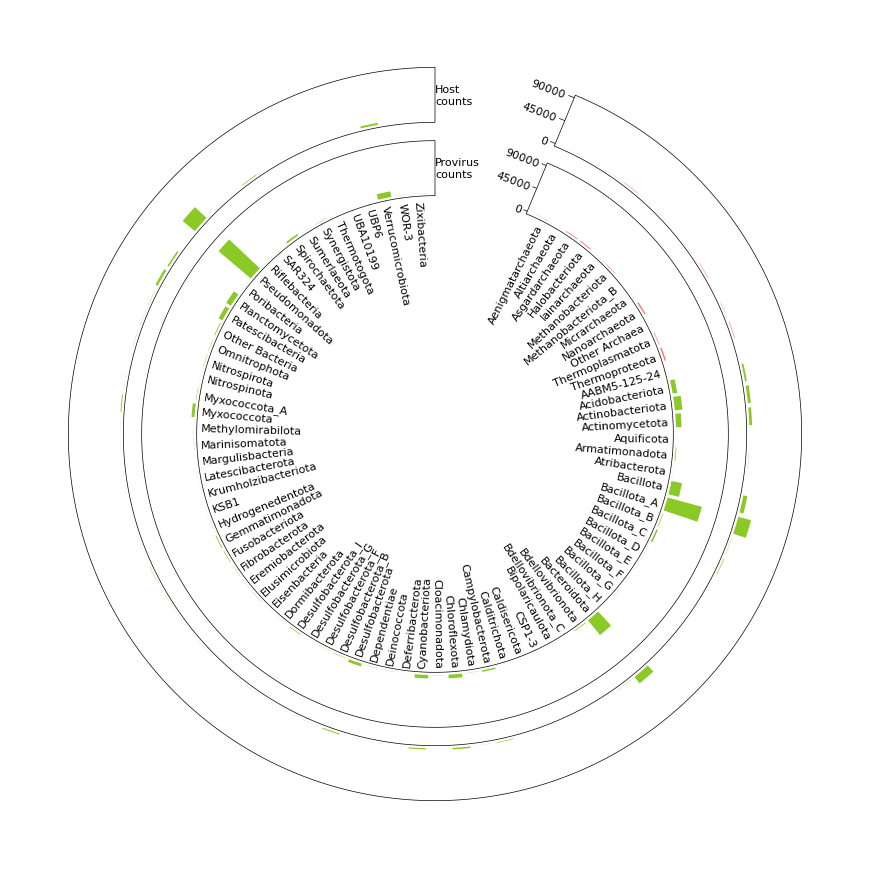

In [10]:
# sectors = {"Archaea": 20, "Bacteria": 80}
sectors = {"all": len(data) + 1}
circos = Circos(
    sectors=sectors, 
    space=0, 
    start=22.5, 
    end=360,
    # show_axis_for_debug=True
)

text_common_kws = dict(ha="left", va="center", size=8)

for sector in circos.sectors:
    x = data["index"].to_numpy() + 1
    c = data["color"].to_numpy()
    ymin, ymax = (0, 90_000)
    yticks = np.array([0, 45_000, 90_000])
    # yticks = np.array([1, 10, 100, 1000, 10000, 100000])

    for ylabel, r_lim in zip(["provirus_count", "host_count"], [(65, 80), (85, 100)]):
        y = data[ylabel].to_numpy()
        # y = np.log10(y)
        bar_track = sector.add_track(r_lim, r_pad_ratio=0.1)
        bar_track.axis()
        bar_track.bar(x, y, width=0.8, color=c, vmin=ymin, vmax=ymax)

        bar_track.yticks(yticks, yticks, side="left")

        if ylabel == "provirus_count":
            bar_track.xticks(
                x,
                labels=data["phyla_label"].to_numpy(),
                outer=False,
                # rotation=90,
                # ha="left",
                # size=10,
                # color="black",
                label_orientation="vertical",
                tick_length=0.1,
                label_margin=1.0,
            )
            ylabel = "Provirus\ncounts"
        else:
            ylabel = "Host\ncounts"

        midpoint = (r_lim[0] + r_lim[1]) / 2

        circos.text(ylabel, r=midpoint, **text_common_kws)

fig = circos.plotfig()